# Newsvendor Intro Example

In [367]:
import cvxpy as cp
import scipy as sc
import numpy as np
import numpy.random as npr
from scipy.spatial.transform import Rotation as R
import torch
from sklearn import datasets
import pandas as pd
import lropt
import sys
sys.path.append('..')
from utils import plot_tradeoff,plot_iters, plot_contours, plot_contours_line
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":24,
    "font.family": "serif"
})

### Example 1: Intro example, max of affine uncertainty
We consider a problem with max of affine uncertainty, 

$$g(u,x) = \max_{l=1,\dots,L} (P_lu + a_l)^Tx,$$
where $P_l$ and $a_l$ are constants for all $l = 1, \dots, L$. The robust formulation is 
$$
\begin{array}{ll}
\text{minimize} & \tau\\
\text{subject to}  & \max_{l=1,\dots,L} (P_lu + a_l)^Tx  \leq  \tau \quad \forall u \in \mathcal{U}(\theta)\\
& x \geq 0,
\end{array}
$$


where $\theta$ encodes the training parameters $(A,b)$.

We formulate the Newsvendor problem with this framework, where we solve
\begin{equation}
	\begin{array}{ll}
		\text{minimize} & \tau\\
		\text{subject to} & k^Tx  + \max\{-p^Tx,- p^Tu\} \le \tau \quad \forall u \in \mathcal{U}(\theta) \\
		& x \geq 0.
	\end{array}
\end{equation}

In [464]:
# Formulate constants
n = 2
N = 1000
test_perc = 0.9
# k = npr.uniform(1,4,n)
# p = k + npr.uniform(2,5,n)
k = np.array([4.,5.])
p = np.array([5,6.5])
# k_tch = torch.tensor(k, requires_grad = True)
# p_tch = torch.tensor(p, requires_grad = True)

def loss(t,x,k_tch, p_tch, alpha,data, l = 5, quantile = 0.95,target = 1.): 
    sums = torch.mean(torch.maximum(
        torch.maximum( k_tch@x -data@(p_tch), k_tch@x - x@(p_tch)) - t - alpha, 
        torch.tensor(0.,requires_grad = True)))
    sums = sums/(1-quantile) + alpha
    sums1 = torch.mean(torch.maximum( k_tch@x -data@(p_tch), k_tch@x - x@(p_tch)))
    return t + l*(sums - target), sums1, torch.mean((torch.maximum(
        torch.maximum(k_tch@x -data@(p_tch), k_tch@x - x@(p_tch)) - t, 
        torch.tensor(0.,requires_grad = True))>=0.001).float()), sums.detach().numpy()

def loss(t,x,y1,d1, y2, d2, k_tch, p_tch, alpha,data, l = 5, quantile = 0.95,target = 1.): 
    Nsample = data.shape[0]
    sums = torch.mean(torch.maximum(k_tch[1]*x[1] + y1 + data[:,0]*d1 + y2 + data[:,1]*d2 - t - alpha,torch.tensor(0.,requires_grad = True) ) + torch.maximum(
        torch.maximum(-data[:,0]*(p_tch[0]),- x[0]*(p_tch[0])) - y1 -  data[:,0]*d1 - alpha, 
        torch.tensor(0.,requires_grad = True)) + torch.maximum(
        torch.maximum(-data[:,1]*(p_tch[1]),- x[1]*(p_tch[1])) - y2 -  data[:,1]*d2 - alpha, 
        torch.tensor(0.,requires_grad = True)))
    # sums =  torch.mean(torch.maximum(k_tch[1]*x[1]+ torch.maximum(-data[:,0]*p_tch[0],- p_tch[0]*x[0])+ torch.maximum(-data[:,1]*p_tch[1],-p_tch[1]*x[1]) - t,  torch.tensor(0.,requires_grad = True)))
    # prob = torch.sum(torch.maximum(k_tch[1]*x[1] + y1 + data[:,0]*d1 + y2 + data[:,1]*d2 - t,torch.tensor(0.,requires_grad = True) ) + torch.maximum(
    #     torch.maximum(-data[:,0]*p_tch[0],- p_tch[0]*x[0]) - y1 - data[:,0]*d1, 
    #     torch.tensor(0.,requires_grad = True))+
    #     torch.maximum(torch.maximum(-data[:,1]*p_tch[1],-p_tch[1]*x[1]) - y2-  data[:,1]*d2,
    #                   torch.tensor(0.,requires_grad = True))>= torch.tensor(0.0001))/Nsample
    probn = torch.sum((torch.maximum(k_tch[1]*x[1]+ torch.maximum(-data[:,0]*p_tch[0],- p_tch[0]*x[0])+ torch.maximum(-data[:,1]*p_tch[1],-p_tch[1]*x[1]) - t,  torch.tensor(0.,requires_grad = True)))>= torch.tensor(0.0001))/Nsample
    sums = sums/(1-quantile) + alpha
    objective = torch.mean(k_tch[1]*x[1] + torch.maximum(-data[:,0]*(p_tch[0]), - x[0]*(p_tch[0]))+ torch.maximum(-data[:,1]*(p_tch[1]), - x[1]*(p_tch[1])))
    return t + l*(sums - target), objective, probn, sums.detach().numpy()


def gen_demand_intro(N, seed):
    np.random.seed(seed)
    sig = np.array([[0.6,-0.4],[-0.3,0.1]])
    mu = np.array((0.9,0.7))
    norms = np.random.multivariate_normal(mu,sig, N)
    d_train = np.exp(norms)
    return d_train

# def gen_demand_intro(N, seed):
#     np.random.seed(seed)
#     sig = np.array([[0.6,-0.3],[-0.3,0.1]])
#     mu = np.array((0.7,0.7))
#     norms = np.random.multivariate_normal(mu,sig, N)
#     d_train = np.exp(norms)
#     return d_train
# Generate data
data = gen_demand_intro(N, seed=5)
data = gen_demand_intro(N, seed=10)

In [465]:
scenarios = {}
num_scenarios = 10
for scene in range(num_scenarios):
  np.random.seed(scene+3)
  scenarios[scene]={}
  scenarios[scene][0] = k + np.random.normal(0,0.3,n)
  scenarios[scene][1] = p + np.random.normal(0,0.2,n)

# scenarios = {}
# num_scenarios = 8
# for scene in range(num_scenarios):
#   np.random.seed(scene+1)
#   scenarios[scene]={}
#   scenarios[scene][0] = np.random.uniform(2,6,n)
#   scenarios[scene][1] =  scenarios[scene][0] + np.random.uniform(2,4,n)

# num_scenarios = 5
# p_data = p + np.random.normal(0,1,(num_scenarios,n))
# k_data = k + np.random.normal(0,1,(num_scenarios,n))

In [667]:
# Formulate uncertainty set
experiment = 3
data = gen_demand_intro(N, seed=experiment)
u = lropt.UncertainParameter(n,
                        uncertainty_set=lropt.Ellipsoidal(p=2,
                                                    data=data, loss = loss))
# Formulate the Robust Problem
x_r = cp.Variable(n)
t = cp.Variable()
k = cp.Parameter(n)
p = cp.Parameter(n)
k.value = scenarios[0][0]
p.value = scenarios[0][1]
y1 = cp.Variable()
y2 = cp.Variable()
d1 = cp.Variable()
d2 = cp.Variable()

objective = cp.Minimize(t)
constraints = [k>= 0, p>= 0]
constraints += [k[1]*x_r[1] + y1 + d1*np.array([1,0])@u + y2 + d2*np.array([0,1])@u <= t]
constraints += [cp.maximum(-p[0]*x_r[1],-p[0]*np.array([1,0])@u)<= y1 + d1*np.array([1,0])@u]
constraints += [cp.maximum(-p[1]*x_r[1],-p[1]*np.array([0,1])@u)<= y2 + d2*np.array([0,1])@u]
constraints += [x_r >= 0]
constraints += [x_r[0] == x_r[1]]
prob = lropt.RobustProblem(objective, constraints)
target = -0.1
s = 13

# setup intial A, b
train, test = train_test_split(data, test_size=int(data.shape[0]*test_perc), random_state=s)
init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(train.T)))
init_bval = -init@np.mean(train, axis=0)
np.random.seed(6)
initn = np.random.rand(n,n)
init_bvaln = -initn@np.mean(train, axis=0)
# Train A and b
result1 = prob.train(lr = 0.00007, step=300, momentum = 0.5, optimizer = "SGD", seed = s, init_A = initn, init_b = init_bvaln, fixb = False, init_lam = 0.05, target_cvar = target, init_alpha = -0.1, test_percentage = test_perc, save_iters= True, scenarios = scenarios, num_scenarios = num_scenarios, step_y = 0.01, batch_percentage = 1.0)
# result1 = prob.train(lr = 0.0001, step=100, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, fixb = False, init_lam = 0.1, target_cvar = target, init_alpha = -0.1, test_percentage = test_perc, save_iters= True, scenarios = scenarios, num_scenarios = num_scenarios, step_y = 0.01, batch_percentage = 0.8)
df1 = result1.df
A_fin = result1.A
b_fin = result1.b

# result3 = prob.train(eps = True, lr = 0.001, step=200, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval,init_lam = 10,  target_cvar = target, init_alpha  =-0.1, test_percentage = test_perc,scenarios = scenarios, num_scenarios = num_scenarios,step_y = 0.1)
# df_r2 = result3.df

In [668]:
# Grid search standard
#np.linspace(0.001, 2.98, 100)

result4 = prob.grid(epslst = np.logspace(-3, 2, 100), init_A = init, init_b = init_bval, seed = s, init_alpha = -0., test_percentage = test_perc,scenarios = scenarios, num_scenarios = num_scenarios)
dfgrid = result4.df

# Grid search reshaped
result5 = prob.grid(epslst = np.logspace(-3, 2, 100), init_A = A_fin, init_b = b_fin, seed = s, init_alpha = -0., test_percentage = test_perc,scenarios = scenarios, num_scenarios = num_scenarios)
dfgrid2 = result5.df

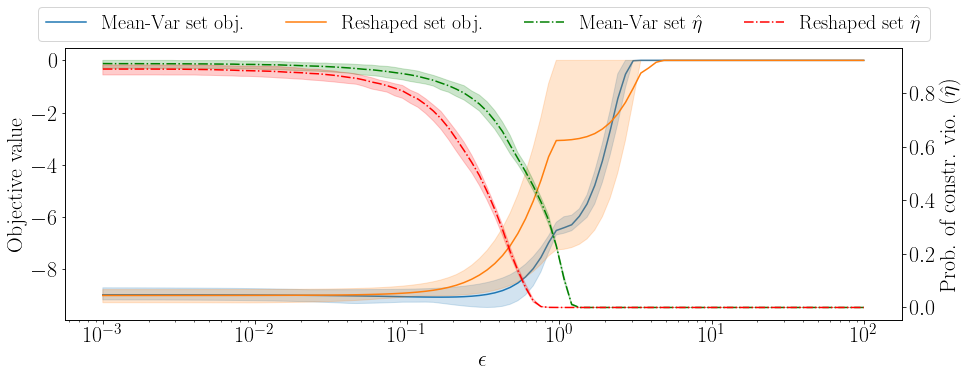

In [669]:
# eps_list = np.linspace(0.01, 2.98, 40)
# inds = [13,8,6,5]
# inds = [20,13,10,7]

fig, ax1 = plt.subplots(figsize=(15, 5))
ax2 = ax1.twinx()
ax1.plot(np.mean(np.vstack(dfgrid['Eps']),axis = 1)[:], np.mean(np.vstack(dfgrid['Test_val']),axis = 1)[:], color="tab:blue",label=r"Mean-Var set obj.",zorder=0)
ax1.fill(np.append(np.quantile(np.vstack(dfgrid['Eps']),0.25,axis = 1),np.quantile(np.vstack(dfgrid['Eps']),0.75,axis = 1)[::-1]), np.append(np.quantile(np.vstack(dfgrid['Test_val']),0.25,axis = 1),np.quantile(np.vstack(dfgrid['Test_val']),0.75,axis = 1)[::-1]), color="tab:blue", alpha=0.2)

ax1.plot(np.mean(np.vstack(dfgrid2['Eps']),axis = 1),np.mean(np.vstack(dfgrid2['Test_val']),axis = 1), color="tab:orange", label="Reshaped set obj.",zorder=1)
ax1.fill(np.append(np.quantile(np.vstack(dfgrid2['Eps']),0.25,axis = 1),np.quantile(np.vstack(dfgrid2['Eps']),0.75,axis = 1)[::-1]), np.append(np.quantile(np.vstack(dfgrid2['Test_val']),0.25,axis = 1),np.quantile(np.vstack(dfgrid2['Test_val']),0.75,axis = 1)[::-1]), color="tab:orange", alpha=0.2)
ax1.set_ylabel("Objective value")
# ax2.set_xlim([-1,20])
ax1.set_xlabel(r"$\epsilon$")
#ax1.set_ylim([-3,15])
ax1.set_xscale("log")

ax2.plot(np.mean(np.vstack(dfgrid['Eps']),axis = 1)[:], np.mean(np.vstack(dfgrid['Violations']),axis = 1)[:], color="green", label=r"Mean-Var set $\hat{\eta}$", linestyle="-.", zorder=0)
ax2.fill(np.append(np.quantile(np.vstack(dfgrid['Eps']),0.25,axis = 1),np.quantile(np.vstack(dfgrid['Eps']),0.75,axis = 1)[::-1]), np.append(np.quantile(np.vstack(dfgrid['Violations']),0.25,axis = 1),np.quantile(np.vstack(dfgrid['Violations']),0.75,axis = 1)[::-1]), color="green", alpha=0.2)
ax2.plot(np.mean(np.vstack(dfgrid2['Eps']),axis = 1),np.mean(np.vstack(dfgrid2['Violations']),axis = 1), color="red", label=r"Reshaped set $\hat{\eta}$", linestyle="-.", zorder=1)
ax2.fill(np.append(np.quantile(np.vstack(dfgrid2['Eps']),0.25,axis = 1),np.quantile(np.vstack(dfgrid2['Eps']),0.75,axis = 1)[::-1]), np.append(np.quantile(np.vstack(dfgrid2['Violations']),0.25,axis = 1),np.quantile(np.vstack(dfgrid2['Violations']),0.75,axis = 1)[::-1]), color="red", alpha=0.2)
ax2.set_ylabel("Prob. of constr. vio. $(\hat{\eta})$")
# fig.legend(loc = "upper center")
fig.legend(bbox_to_anchor=(0.1, 0.9, 0, 0), loc="lower left",
                 borderaxespad=0, ncol=4, fontsize = 20)
plt.savefig("ex1_curves_new.pdf", bbox_inches='tight')


In [670]:
def plot_coverage(df_standard,df_reshape,title,ind_1 = (0,100), ind_2 = (0,100)):
    plt.rcParams.update({
    "text.usetex":True,

    "font.size":22,
    "font.family": "serif"
})
    beg1,end1 = ind_1
    beg2,end2 = ind_2

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 3))
    ax1.plot(np.mean(np.vstack(df_standard['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(df_standard['Test_val']),axis = 1)[beg1:end1], color="tab:blue", label=r"Standard set")
    ax1.fill(np.append(np.quantile(np.vstack(df_standard['coverage_test']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['coverage_test']),0.9,axis = 1)[beg1:end1][::-1]), np.append(np.quantile(np.vstack(df_standard['Test_val']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['Test_val']),0.90,axis = 1)[beg1:end1][::-1]), color="tab:blue", alpha=0.2)

    ax1.plot(np.mean(np.vstack(df_reshape['coverage_test']),axis = 1)[beg2:end2],np.mean(np.vstack(df_reshape['Test_val']),axis = 1)[beg2:end2], color = "tab:orange",label=r"Reshaped set")
    ax1.fill(np.append(np.quantile(np.vstack(df_reshape['coverage_test']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['coverage_test']),0.9,axis = 1)[beg2:end2][::-1]), np.append(np.quantile(np.vstack(df_reshape['Test_val']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['Test_val']),0.90,axis = 1)[beg2:end2][::-1]), color="tab:orange", alpha=0.2)

    ax1.ticklabel_format(style="sci",axis='y',scilimits = (0,0), useMathText=True)
    ax1.set_xlabel("Test set coverage")
    ax1.set_ylabel("Objective value")
    ax1.legend()

    ax2.plot(np.mean(np.vstack(df_standard['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(df_standard['Violations']),axis = 1)[beg1:end1], color="tab:blue", label=r"Standard set")

    ax2.plot(np.mean(np.vstack(df_reshape['coverage_test']),axis = 1)[beg2:end2], np.mean(np.vstack(df_reshape['Violations']),axis = 1)[beg2:end2], color="tab:orange", label=r"Reshaped set", alpha = 0.8)
    ax2.set_ylabel("Prob. of cons. vio.")
    ax2.set_xlabel("Test set coverage")
    # ax2.ticklabel_format(style="sci",axis='y',scilimits = (0,0), useMathText=True)
    ax2.legend()
    # plt.savefig(title+"_curve.pdf",bbox_inches='tight')
    plt.show()

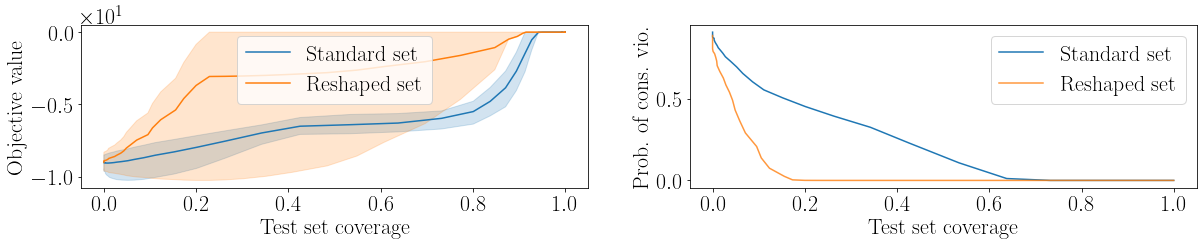

In [671]:
plot_coverage(dfgrid,dfgrid2,"News",ind_1=(0,500),ind_2=(0,500))

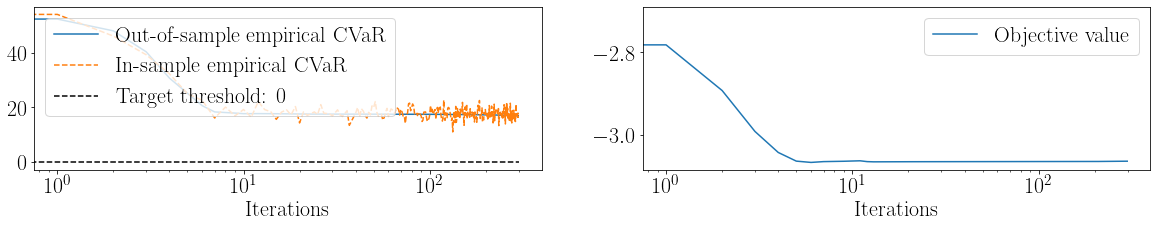

In [672]:
plot_iters(df1,"News", steps = 800,logscale = 1)

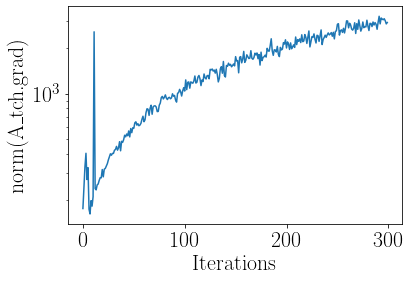

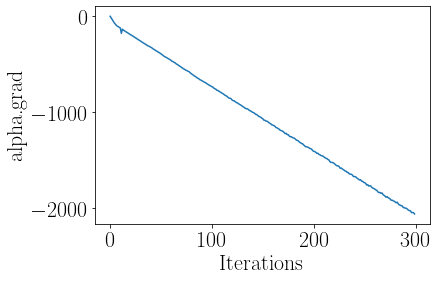

Text(0, 0.5, 'alpha')

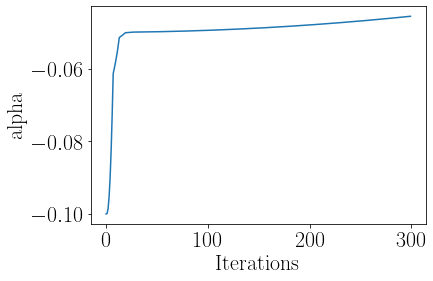

In [673]:
plt.plot(df1["dfnorm"])
plt.xlabel("Iterations")
plt.ylabel("norm(A_tch.grad)")
plt.yscale("log")
plt.show()
plt.plot(df1["alphagrad"])
plt.xlabel("Iterations")
plt.ylabel("alpha.grad")
plt.show()

plt.plot(df1["alpha"])
plt.xlabel("Iterations")
plt.ylabel("alpha")

In [674]:
eps_list = np.logspace(-3, 2, 100)
prob_list = np.array([0.,0.01,0.05,0.1])
inds_standard = []
inds_reshaped = []
for i in prob_list:
    inds_standard.append(np.absolute(np.mean(np.vstack(dfgrid['Violations']),axis = 1)-i).argmin())
    inds_reshaped.append(np.absolute(np.mean(np.vstack(dfgrid2['Violations'][:320]),axis = 1)-i).argmin())
st_eps = eps_list [inds_standard[0]]
re_eps = eps_list [inds_reshaped[0]]
st_eps, re_eps

(1.3530477745798062, 1.072267222010323)

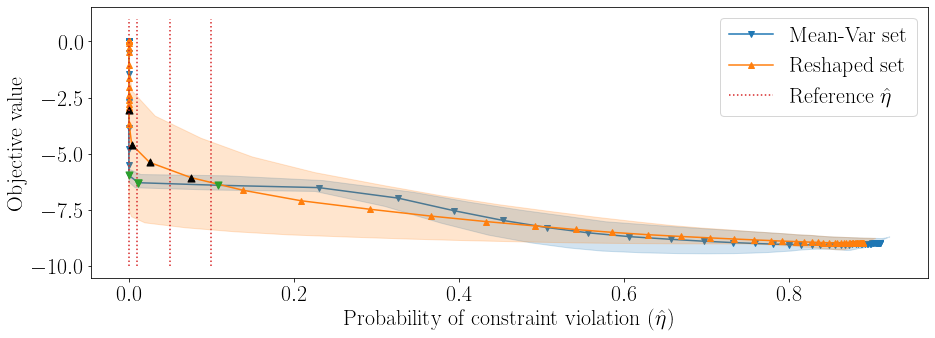

In [675]:
# eps_list = np.linspace(0.01, 2.98, 40)
# inds = [13,8,6,5]
# inds = [20,13,10,7]
# eps_list = np.linspace(0.001, 2.98, 80)
beg1, end1 = 0,500
beg2, end2 = 0,500
plt.figure(figsize=(15, 5))
plt.plot(np.mean(np.vstack(dfgrid['Violations']),axis = 1)[beg1:end1], np.mean(np.vstack(dfgrid['Test_val']),axis = 1)[beg1:end1], color="tab:blue", label=r"Mean-Var set", marker = "v",zorder=0)
plt.fill(np.append(np.quantile(np.vstack(dfgrid['Violations']),0.25,axis = 1)[beg1:end1],np.quantile(np.vstack(dfgrid['Violations']),0.75,axis = 1)[beg1:end1][::-1]), np.append(np.quantile(np.vstack(dfgrid['Test_val']),0.25,axis = 1)[beg1:end1],np.quantile(np.vstack(dfgrid['Test_val']),0.75,axis = 1)[beg1:end1][::-1]), color="tab:blue", alpha=0.2)
for ind in range(4):
    plt.scatter(np.mean(np.vstack(dfgrid['Violations']),axis = 1)[inds_standard[ind]],np.mean(np.vstack(dfgrid['Test_val']),axis = 1)[inds_standard[ind]], color="tab:green", s = 50, marker = "v",zorder= 10)
plt.plot(np.mean(np.vstack(dfgrid2['Violations']),axis = 1)[beg2:end2],np.mean(np.vstack(dfgrid2['Test_val']),axis = 1)[beg2:end2], color="tab:orange", label="Reshaped set", marker = "^",zorder=1)
plt.fill(np.append(np.quantile(np.vstack(dfgrid2['Violations']),0.25,axis = 1)[beg2:end2],np.quantile(np.vstack(dfgrid2['Violations']),0.75,axis = 1)[beg2:end2][::-1]), np.append(np.quantile(np.vstack(dfgrid2['Test_val']),0.25,axis = 1)[beg2:end2],np.quantile(np.vstack(dfgrid2['Test_val']),0.75,axis = 1)[beg2:end2][::-1]), color="tab:orange", alpha=0.2)
for ind in [0,2,1,3]:
    plt.scatter(np.mean(np.vstack(dfgrid2['Violations']),axis = 1)[inds_reshaped[ind]],np.mean(np.vstack(dfgrid2['Test_val']),axis = 1)[inds_reshaped[ind]], color="black", s = 50, marker = "^")
plt.ylabel("Objective value")
# ax2.set_xlim([-1,20])
plt.xlabel(r"Probability of constraint violation $(\hat{\eta})$")
#plt.xscale("log")
# plt.ylim([-2,1])
plt.vlines(ymin = -10, ymax= 1, x = prob_list[0], linestyles=":", color = "tab:red", label = "Reference $\hat{\eta}$")
for i in prob_list[1:]:
    plt.vlines(ymin = -10, ymax= 1, x = i, linestyles=":", color = "tab:red")

plt.legend()
# lgd = plt.legend(loc = "lower right", bbox_to_anchor=(1.5, 0.3))
plt.savefig("ex1_curves_orig.pdf", bbox_inches='tight')
# plt.savefig("ex1_curves1.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')


In [676]:
# A_new = np.load("A_fin.npy")
# b_new = np.load("b_fin.npy")
# dfgrid.to_pickle("dfst_test.pkl")
# dfgrid2.to_pickle("dfre_test.pkl")

In [677]:
theta = np.radians(0)
c, s = np.cos(theta), np.sin(theta)
rotation = np.array(((c, -s), (s, c)))
# rotation = np.eye(2)
# rotation = sc.stats.special_ortho_group.rvs(2)
# rotation
k = np.array([4.,5.])
p = np.array([5,6.5])
x_opt_base = {}
x_opt_learned = {}
t_learned = {}
y1_learned = {}
y2_learned = {}
d1_learned = {}
d2_learned = {}
t_base = {}
y1_base = {}
y2_base = {}
d1_base = {}
d2_base = {}
for ind in range(4):
    x_opt_base[ind] = {}
    x_opt_learned[ind] = {}
    t_learned[ind] = {}
    t_base[ind] = {}
    y1_learned[ind]= {}
    y2_learned[ind] = {}
    d1_learned[ind] = {}
    d2_learned[ind] = {}
    y1_base[ind] = {}
    y2_base[ind] = {}
    d1_base[ind] = {}
    d2_base[ind]= {}
    for scene in range(num_scenarios):
        n = 2
        u = lropt.UncertainParameter(n,
                                uncertainty_set=lropt.Ellipsoidal(p=2,
                                                            A = (1/eps_list[inds_standard[ind]])*init@rotation, b = (1/eps_list[inds_standard[ind]])*init@rotation@np.linalg.inv(init)@init_bval))
        # Formulate the Robust Problem
        x_r = cp.Variable(n)
        t = cp.Variable()
        k = cp.Parameter(n)
        p = cp.Parameter(n)
        k.value = scenarios[scene][0]
        p.value = scenarios[scene][1]
        y1 = cp.Variable()
        y2 = cp.Variable()
        d1 = cp.Variable()
        d2 = cp.Variable()

        objective = cp.Minimize(t)
        constraints = [k>= 0, p>= 0]
        constraints += [k[1]*x_r[1] + y1 + d1*np.array([1,0])@u + y2 + d2*np.array([0,1])@u <= t]
        constraints += [cp.maximum(-p[0]*x_r[1],-p[0]*np.array([1,0])@u)<= y1 + d1*np.array([1,0])@u]
        constraints += [cp.maximum(-p[1]*x_r[1],-p[1]*np.array([0,1])@u)<= y2 + d2*np.array([0,1])@u]
        constraints += [x_r >= 0]
        constraints += [x_r[0]==x_r[1]]


        prob = lropt.RobustProblem(objective, constraints)
        prob.solve()
        # result3.reform_problem.solve()
        x_opt_base[ind][scene] = x_r.value
        d1_base[ind][scene] = d1.value
        d2_base[ind][scene] = d2.value
        t_base[ind][scene] = t.value
        y1_base[ind][scene] = y1.value
        y2_base[ind][scene] = y2.value
        n = 2
        u = lropt.UncertainParameter(n,
                                uncertainty_set=lropt.Ellipsoidal(p=2,
                                                            A = (1/eps_list[inds_reshaped[ind]])*A_fin@rotation, b = (1/eps_list[inds_reshaped[ind]])*A_fin@rotation@np.linalg.inv(A_fin)@b_fin))
        # Formulate the Robust Problem
        x_r = cp.Variable(n)
        t = cp.Variable()
        k = cp.Parameter(n)
        p = cp.Parameter(n)
        k.value = scenarios[scene][0]
        p.value = scenarios[scene][1]
        y1 = cp.Variable()
        y2 = cp.Variable()
        d1 = cp.Variable()
        d2 = cp.Variable()

        objective = cp.Minimize(t)
        constraints = [k>= 0, p>= 0]
        constraints += [k[1]*x_r[1] + y1 + d1*np.array([1,0])@u + y2 + d2*np.array([0,1])@u <= t]
        constraints += [cp.maximum(-p[0]*x_r[1],-p[0]*np.array([1,0])@u)<= y1 + d1*np.array([1,0])@u]
        constraints += [cp.maximum(-p[1]*x_r[1],-p[1]*np.array([0,1])@u)<= y2 + d2*np.array([0,1])@u]
        constraints += [x_r >= 0]
        constraints += [x_r[0]==x_r[1]]
        
        prob = lropt.RobustProblem(objective, constraints)
        prob.solve()
        # result3.reform_problem.solve()
        x_opt_learned[ind][scene] = x_r.value
        d1_learned[ind][scene] = d1.value
        d2_learned[ind][scene] = d2.value
        t_learned[ind][scene] = t.value
        y1_learned[ind][scene] = y1.value
        y2_learned[ind][scene] = y2.value
        x_opt_learned,x_opt_base,t_learned, t_base
    # A_fin, init, b_fin, init_bval
# x_opt_learned,x_opt_base,t_learned, t_base
A_fin, b_fin, init, init_bval

(array([[ 0.81638178,  0.48904342],
        [ 0.91685751, -0.08278971]]),
 array([-3.72304231, -2.80774925]),
 array([[0.47433106, 0.22871394],
        [0.22871394, 1.05705846]]),
 array([-2.09488343, -3.12339468]))

In [678]:
n = 2
u = lropt.UncertainParameter(n,
        uncertainty_set=lropt.Ellipsoidal(p=2,
                                        A = A_fin, b = b_fin))
# Formulate the Robust Problem
x_r = cp.Variable(n)
t = cp.Variable()
k = cp.Parameter(n)
p = cp.Parameter(n)
k.value = scenarios[scene][0]
p.value = scenarios[scene][1]
y1 = cp.Variable()
y2 = cp.Variable()
d1 = cp.Variable()
d2 = cp.Variable()

objective = cp.Minimize(t)
constraints = [k>= 0, p>= 0]
constraints += [k@x_r + y1 + d1*np.array([1,0])@u + y2 + d2*np.array([0,1])@u <= t]
constraints += [cp.maximum(-p[0]*x_r[0],-p[0]*np.array([1,0])@u)<= y1 + d1*np.array([1,0])@u]
constraints += [cp.maximum(-p[1]*x_r[1],-p[1]*np.array([0,1])@u)<= y2 + d2*np.array([0,1])@u]
constraints += [x_r >= 0]


prob = lropt.RobustProblem(objective, constraints)
prob.solve()
loss(torch.tensor(t.value), torch.tensor(x_r.value),torch.tensor(y1.value),torch.tensor(d1.value),torch.tensor(y2.value),torch.tensor(d2.value),torch.tensor(k.value), torch.tensor(p.value),0,torch.tensor(test))

torch.sum(torch.maximum(torch.tensor(k.value)@torch.tensor(x_r.value) + torch.tensor(y1.value) + torch.tensor(test)[:,0]*torch.tensor(d1.value) + torch.tensor(y2.value) + torch.tensor(test)[:,1]*torch.tensor(d2.value) - torch.tensor(t.value),torch.tensor(0.,requires_grad = True) ) + torch.maximum(
        torch.maximum(-torch.tensor(test)[:,0]*torch.tensor(p.value)[0],-torch.tensor(p.value)[0]*torch.tensor(x_r.value)[0]) - torch.tensor(y1.value) - torch.tensor(test)[:,0]*torch.tensor(d1.value), 
        torch.tensor(0.,requires_grad = True))+
        torch.maximum(torch.maximum(-torch.tensor(test)[:,1]*torch.tensor(p.value)[1],-torch.tensor(p.value)[1]*torch.tensor(x_r.value)[1]) - torch.tensor(y2.value)-  torch.tensor(test)[:,1]*torch.tensor(d2.value),
                      torch.tensor(0.,requires_grad = True))>= torch.tensor(0.001))

tensor(900)

In [679]:
K =1
num_p = 50
offset = 2
x_min, x_max = np.min(train[:,0]) - offset, np.max(train[:,0]) + offset
y_min, y_max = np.min(train[:,1]) - offset, np.max(train[:,1]) + offset
X = np.linspace(x_min,x_max,num_p)
Y = np.linspace(y_min,y_max,num_p)
x,y = np.meshgrid(X,Y)
# Z values as a matrix
fin_set = {}
init_set = {}
for ind in range(4):
    fin_set[ind] = {}
    init_set[ind] = {}
    for k_ind in range(K):
        fin_set[ind][k_ind] = np.zeros((num_p,num_p))
        init_set[ind][k_ind] = np.zeros((num_p,num_p))
g_level_learned = {}
g_level_base = {}
for ind in range(4):
    g_level_learned[ind] = {}
    g_level_base[ind] = {}
    for scene in range(num_scenarios):
        g_level_learned[ind][scene] = np.zeros((num_p,num_p))
        g_level_base[ind][scene] = np.zeros((num_p,num_p))
# init_set = np.zeros((num_p,num_p))
    # Populate Z Values (a 7x7 matrix) - For a circle x^2+y^2=z
    for i in range(num_p):
        for j in range(num_p):
            u_vec = [x[i,j], y[i,j]]
            for k_ind in range(K):
                # fin_set[ind][k_ind][i,j] = np.linalg.norm((1/eps_list[inds_reshaped[ind]])*A_fin[k_ind*n:(k_ind+1)*n, 0:n]@ u_vec + (1/eps_list[inds_reshaped[ind]])*b_fin)
                fin_set[ind][k_ind][i,j] = np.linalg.norm((1/eps_list[inds_reshaped[ind]])*A_fin[k_ind*n:(k_ind+1)*n, 0:n]@ rotation@(u_vec + np.linalg.inv(A_fin[k_ind*n:(k_ind+1)*n, 0:n])@b_fin))
                
            for k_ind in range(K):
                # init_set[ind][k_ind][i,j] = np.linalg.norm((1/eps_list[inds_standard[ind]])*init[k_ind*n:(k_ind+1)*n, 0:n]@ u_vec  + (1/eps_list[inds_standard[ind]])*init_bval)
                init_set[ind][k_ind][i,j] = np.linalg.norm((1/eps_list[inds_standard[ind]])*init[k_ind*n:(k_ind+1)*n, 0:n]@ rotation@(u_vec  + np.linalg.inv(init[k_ind*n:(k_ind+1)*n, 0:n])@init_bval))
                # init_set[ind][k_ind][i,j] = np.linalg.norm((1/eps_list[inds_standard[ind]])*initn[k_ind*n:(k_ind+1)*n, 0:n]@ rotation@(u_vec  + np.linalg.inv(initn[k_ind*n:(k_ind+1)*n, 0:n])@init_bvaln))
            for scene in range(num_scenarios):
                g_level_learned[ind][scene][i,j] = scenarios[scene][0][1]*x_opt_learned[ind][scene][0] + np.maximum(- scenarios[scene][1][0]* x_opt_learned[ind][scene][0],- scenarios[scene][1][0]* u_vec[0])  + np.maximum(- scenarios[scene][1][1]* x_opt_learned[ind][scene][1],- scenarios[scene][1][1]* u_vec[1])  - t_learned[ind][scene]
                # scenarios[scene][0]@x_opt_learned[ind][scene] + y1_learned[ind][scene] + d1_learned[ind][scene]*u_vec[0] +  y2_learned[ind][scene] + d2_learned[ind][scene]*u_vec[1] - t_learned[ind][scene]
                
                g_level_base[ind][scene][i,j] =scenarios[scene][0][1]*x_opt_base[ind][scene][0]  + np.maximum(- scenarios[scene][1][0]* x_opt_base[ind][scene][0],- scenarios[scene][1][0]* u_vec[0])  + np.maximum(- scenarios[scene][1][1]* x_opt_base[ind][scene][1],- scenarios[scene][1][1]* u_vec[1])  - t_base[ind][scene]
                 #scenarios[scene][0]@x_opt_base[ind][scene] + y1_base[ind][scene] + d1_base[ind][scene]*u_vec[0] +  y2_base[ind][scene] + d2_base[ind][scene]*u_vec[1]  - t_base[ind][scene]

In [680]:

def plot_contours_line(x,y,set, g_level,prob_list, num_scenarios,train, title, standard = True):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 3.5), constrained_layout= True)
    ax_lst = [ax1, ax2, ax3, ax4]

    cur_ind = 0
    for axis in ax_lst:
        axis.set_title(r'$\hat{\eta}$' + ' = {}'.format(prob_list[cur_ind]))
        axis.set_xlabel(r"$u_1$")
        axis.set_ylabel(r"$u_2$")
        for scene in range(num_scenarios):
            axis.contour(x,y,g_level[cur_ind][scene],[0], colors = ["tab:purple"],alpha = 1,linestyles = ["-"])
        axis.scatter(train[:,0],train[:,1], color = "white",edgecolor = "black")
        axis.scatter(np.mean(train,axis= 0)[0], np.mean(train,axis= 0)[1],color = ["tab:green"])
        for k_ind in range(1):
            axis.contour(x,y,set[cur_ind][k_ind], [1], colors = ["red"],linewidths = [2])
        cur_ind +=1
    if standard:
        post = "Mean-Variance"
    else:
        post = "Reshaped"
    fig.suptitle(post+" set", fontsize = 30)
    plt.savefig(title+"_"+ post + ".pdf", bbox_inches='tight')


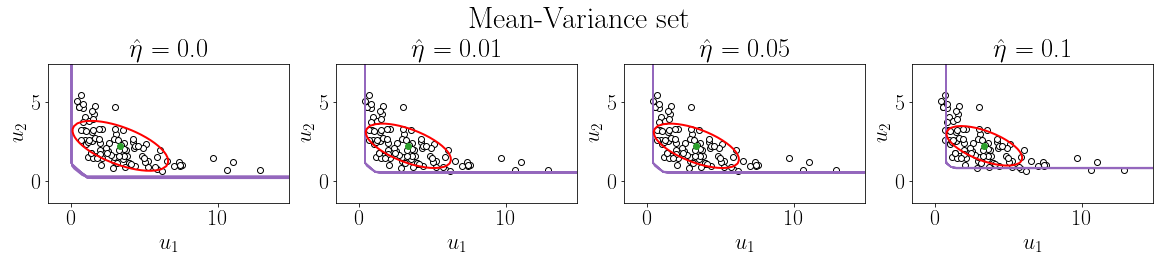

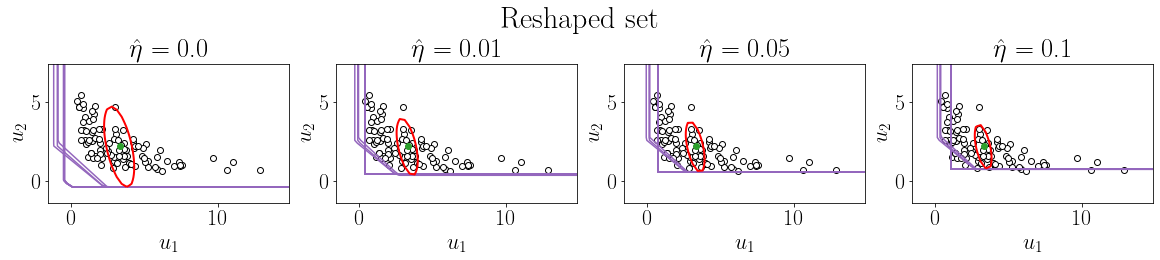

In [681]:
plot_contours_line(x,y,init_set, g_level_base,prob_list,num_scenarios,train, "news_intro",standard = True) 
plot_contours_line(x,y,fin_set, g_level_learned,prob_list,num_scenarios,train, "news_intro",standard = False)

In [630]:
A_fin/initn

array([[0.9732182 , 1.00147248],
       [0.99325646, 0.96235673]])

In [556]:
b_fin/init_bvaln

array([0.99359415, 0.96356955])

In [106]:
A_fin/A_new, b_fin/b_new

(array([[1.04505694, 1.16042619],
        [0.99743004, 1.02058556]]),
 array([1.01761403, 1.02229295]))

## Alternating min max

In [179]:
def createproblem_max(A,b):
    # PARAMETERS #
    u = cp.Variable(n)
    objective = cp.Maximize(-p@u)
    constraints = [cp.norm(A@u + b)<= 1]

    # PROBLEM #
    problem = cp.Problem(objective, constraints)
    return problem, u


def createproblem_min(Uvals, n_planes):
    # PARAMETERS #
    x = cp.Variable(n)
    t = cp.Variable()

    # CONSTRAINTS #
    objective = t
    constraints = [x>=0]
    for index in range(n_planes):
        constraints += [cp.maximum(k@x - p@x, k@x - p@Uvals[index]) <= t]
    # PROBLEM #
    problem = cp.Problem(cp.Minimize(objective), constraints)
    return problem, x, t

def minmaxsolve(probmin, probmax):
    Uvals = {}
    inds = 0
    Uvals[inds] = np.array([2.8, 2.3])
    inds += 1
    solvetime = 0
    problem1, x, t = probmin(Uvals, inds)
    problem1.solve()
    objs1 = problem1.objective.value
    solvetime += problem1.solver_stats.solve_time
    problem, u = probmax(A_fin, b_fin)
    problem.solve()
    solvetime += problem.solver_stats.solve_time
    Uvals[inds] = u.value
    inds += 1
    problem1, x, t = probmin(Uvals, inds)
    problem1.solve()
    solvetime += problem1.solver_stats.solve_time
    objs2 = problem1.objective.value
    while (np.abs(objs1 - objs2) >= 0.0001 and inds <= 10):
        problem.solve()
        solvetime += problem.solver_stats.solve_time
        Uvals[inds] = u.value
        inds += 1
        problem1, x,t = probmin(Uvals, inds)
        problem1.solve()
        solvetime += problem1.solver_stats.solve_time
        objs1 = objs2
        objs2 = problem1.objective.value
    return objs2, x.value, t.value, solvetime, inds, Uvals

In [180]:
minmaxsolve(createproblem_min, createproblem_max)

(-6.711490669658791,
 array([3.35536154e+00, 2.00114518e-08]),
 array(-6.71149067),
 9.9459e-05,
 3,
 {0: array([2.8, 2.3]),
  1: array([1.67937481, 1.26904497]),
  2: array([1.67937481, 1.26904497])})

In [626]:
x_cvxpy = cp.Variable(n)
t = cp.Variable()

k.value = scenarios[3][0]
p.value = scenarios[3][1]

rho = 0.9
Amat= (1/rho)*A_fin
bvec = (1/rho)* b_fin
# Amat= (1/rho)*init
# bvec = (1/rho)*init_bval
# formulate objective
objective = cp.Minimize(t)

# formulate constraints
constraints = [(k-p)@x_cvxpy + cp.norm(np.linalg.inv(Amat.T)@p,2) <= t]
constraints += [k@x_cvxpy + bvec@np.linalg.inv(Amat.T)@(p) + cp.norm(np.linalg.inv(Amat.T)@p,2) <= t]
constraints += [x_cvxpy >= 0]

# formulate problem 
prob_cvxpy = cp.Problem(objective, constraints)
prob_cvxpy.solve()
print("Cvxpy objective value: ", prob_cvxpy.objective.value, "\nCvxpy x: ", x_cvxpy.value)
print("Test value: ", np.mean(np.maximum( k.value@x_cvxpy.value -test@(p.value), k.value@x_cvxpy.value - x_cvxpy.value@(p.value))))

Cvxpy objective value:  0.4058368343280443 
Cvxpy x:  [4.80639360e+00 4.92101313e-11]
Test value:  -4.633147200283672


In [627]:
rho = 0.9
Amat= (1/rho)*A_fin
bvec = (1/rho)* b_fin
u = lropt.UncertainParameter(n,
                             uncertainty_set=lropt.Ellipsoidal(p=2, rho=1,A = Amat, b =bvec))
# formulate cvxpy variables
x_r = cp.Variable(n)
t = cp.Variable()

# formulate constants

# formulate objective
objective = cp.Minimize(t)

# formulate constraints 
constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
constraints += [x_r >= 0]


# formulate Robust Problem
prob_robust = lropt.RobustProblem(objective, constraints)

# solve
prob_robust.solve()
print("LRO objective value: ", prob_robust.objective.value, "\nLRO x: ", x_r.value)
print("Test value: ", np.mean(np.maximum( k.value@x_r.value -test@(p.value), k.value@x_r.value - x_r.value@(p.value))))

LRO objective value:  -4.141656031437648 
LRO x:  [ 3.64229947e+00 -7.87541753e-11]
Test value:  -4.086944664562202


In [639]:
rho = 0.9
Amat= (1/rho)*A_fin
bvec = (1/rho)* b_fin
u = lropt.UncertainParameter(n,
                             uncertainty_set=lropt.Ellipsoidal(p=2, rho=1,A = Amat, b =bvec))
# Formulate the Robust Problem
x_r = cp.Variable(n)
t = cp.Variable()
k = cp.Parameter(n)
p = cp.Parameter(n)
k.value = scenarios[9][0]
p.value = scenarios[9][1]
y1 = cp.Variable()
y2 = cp.Variable()
d1 = cp.Variable()
d2 = cp.Variable()

objective = cp.Minimize(t)
constraints = [k>= 0, p>= 0]
constraints += [k@x_r + y1 + d1*np.array([1,0])@u + y2 + d2*np.array([0,1])@u <= t]
constraints += [cp.maximum(-p[0]*x_r[1],-p[0]*np.array([1,0])@u)<= y1 + d1*np.array([1,0])@u]
constraints += [cp.maximum(-p[1]*x_r[1],-p[1]*np.array([0,1])@u)<= y2 + d2*np.array([0,1])@u]
constraints += [x_r >= 0]

prob = lropt.RobustProblem(objective, constraints)
prob.solve()
print("Test value: ", k.value@x_r.value + np.mean(np.maximum(-test[:,0]*(p.value[0]),- x_r.value[0]*(p.value[0]))) + np.mean(np.maximum(-test[:,1]*(p.value[1]),- x_r.value[1]*(p.value[1]))))

Test value:  -1.3726982743375764


In [636]:
eps_list[inds_reshaped]

array([1.40053055, 1.19165984, 1.01393946, 0.90346602])

In [77]:
np.mean(dfgrid2.iloc[58]["Test_val"])

-10.019275544709819

## GIF

In [191]:
A_fin = result1.A
b_fin = result1.b
A1_iters, b1_iters = result1.uncset_iters

In [151]:
x = cp.Variable(n)
u = lropt.UncertainParameter(n,
        uncertainty_set=lropt.Ellipsoidal(data = u.data))
constraints = [(a + Bu)@x <= d]
objective = cp.Minimize(cp.quad_form(P,x) + q@x)
problem = lropt.RobustProblem(objective, constraints)
problem.train()

AttributeError: 'UncertainParameter' object has no attribute 'data'

In [192]:
def newsvendor_prob(A_final, b_final, scene):
    n = 2
    u = lropt.UncertainParameter(n,uncertainty_set=lropt.Ellipsoidal(p=2, A = A_final, b = b_final))
    # Formulate the Robust Problem
    x_r = cp.Variable(n)
    t = cp.Variable()
    k = scenarios[scene][0]
    p = scenarios[scene][1]
    # y = cp.Variable()

    objective = cp.Minimize(t)

    constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
    # constraints += [cp.maximum(k1@(x_r-u),0) <= y]
    # constraints = [cp.maximum(u@k + k1@x_r -u@(k + k1), u@k + k1@x_r - x_r@(k + k1))<=t]

    constraints += [x_r >= 0]

    prob = lropt.RobustProblem(objective, constraints)
    prob.solve()
    t_opt = t.value
    x_opt = x_r.value

    return x_opt, t_opt

In [312]:
offset = 1
x_min, x_max = np.min(train[:,0]) - 3*offset, np.max(train[:,0]) + offset
y_min, y_max = np.min(train[:,1]) - offset, np.max(train[:,1]) + offset
n_points = 100
X = np.linspace(x_min,x_max,n_points)
Y = np.linspace(y_min,y_max,n_points)
x_mesh,y_mesh = np.meshgrid(X,Y)

def optimal_sols(A_final, b_final, num_scenarios):
    x_opt = {}
    t_opt = {}
    for scene in range(num_scenarios):
        x_opt[scene], t_opt[scene] = newsvendor_prob(A_final, b_final, scene)
    return x_opt, t_opt

def level_set(A_final, b_final, offset = 2, n = n_points, x_mesh = x_mesh, y_mesh = y_mesh):
    unc_level_set = np.zeros((n,n))
    g_level_set = np.zeros((num_scenarios,n,n))
    x_opt,t_opt = optimal_sols(A_final, b_final, num_scenarios)
    for i in range(n):
        for j in range(n):
            u_vec = [x_mesh[i,j], y_mesh[i,j]]
            unc_level_set[i,j] = np.linalg.norm(A_final @ u_vec  + b_final)
            for scene in range(num_scenarios):
                g_level_set[scene,i,j] = np.maximum(scenarios[scene][0] @ x_opt[scene] - scenarios[scene][1] @ x_opt[scene], scenarios[scene][0] @ x_opt[scene] - scenarios[scene][1] @ u_vec) - t_opt[scene]

    return unc_level_set, g_level_set

In [313]:
unc_level_learned, g_level_learned = level_set(A_fin, b_fin)
unc_level_base, g_level_base = level_set(init, init_bval)

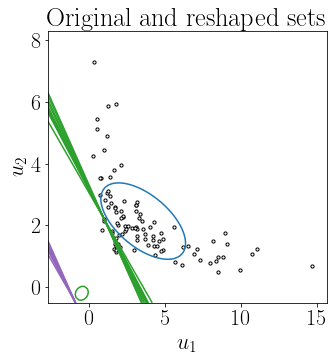

In [315]:
plt.figure(figsize=(5, 5))
plt.title("Original and reshaped sets")
# Set axis label for the contour plot
plt.xlabel(r"$u_1$")
plt.ylabel(r"$u_2$")

plt.contour(x_mesh,y_mesh,unc_level_base, [1], colors = ["tab:blue"], label = "Initial Set")
plt.contour(x_mesh,y_mesh,unc_level_learned, [1], colors = ["tab:green"], label = "Final Set")
for scene in range(num_scenarios):
    plt.contour(x_mesh,y_mesh,g_level_learned[scene,:,:], [1], colors = ["tab:purple"], label = "Initial Set")
    plt.contour(x_mesh,y_mesh,g_level_base[scene,:,:], [1], colors = ["tab:green"], label = "Final Set")

plt.scatter(train[:,0],train[:,1], color = "white",edgecolors= "black", s = 10)
# plt.savefig("Reshaped_ctrs.pdf", bbox_inches='tight')
plt.show()

In [201]:
import os
import imageio

filenames = []
for i in range(10):
    # 
    unc_level, g_level = level_set(A1_iters[i], b1_iters[i])
    plt.figure(figsize=(5, 5))
    plt.title("Original and reshaped sets")
    # Set axis label for the contour plot
    plt.xlabel(r"$u_1$")
    plt.ylabel(r"$u_2$")

    plt.contour(x_mesh,y_mesh,unc_level_base, [1], colors = ["tab:blue"], label = "Initial Set")
    plt.contour(x_mesh,y_mesh,unc_level, [1], colors = ["tab:red"], label = "trained Set")
    plt.contour(x_mesh,y_mesh,unc_level_learned, [1], colors = ["tab:green"], label = "Final Set")
    for scene in range(num_scenarios):
        plt.contour(x_mesh,y_mesh,g_level[scene,:,:], [1], colors = ["tab:purple"], label = "Initial Set")

    filename = f'gif_images/{i}.png'
    filenames.append(filename)

    plt.scatter(train[:,0],train[:,1], color = "white",edgecolors= "black", s = 10)
    plt.savefig(filename)
    plt.close()

with imageio.get_writer('gifs/newsvendor.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

In [118]:
from cvxpylayers.torch import CvxpyLayer
x = cp.Variable(2)
t = cp.Variable()
y = cp.Parameter(2)
z = cp.Parameter((2,2))
objective = cp.Minimize(x@y + t)
constraints = [3*x>= y, t>=0, cp.sum(z)>=0]
problem = cp.Problem(objective, constraints)
y.value = [1,1]
z.value = np.ones((2,2))
problem.solve()

0.6666666666910839

In [172]:
cvxpylayer = CvxpyLayer(problem, parameters=problem.parameters(),
                                variables=problem.variables())

In [187]:
y_tch = torch.stack([torch.tensor([2,1], dtype=torch.double), torch.tensor([1,1], dtype=torch.double)])
z_tch = torch.stack([torch.tensor(2), torch.tensor(1)])
y_tch, z_tch

(tensor([[2., 1.],
         [1., 1.]], dtype=torch.float64),
 tensor([2, 1]))

In [192]:
var_values = cvxpylayer(y_tch, torch.tensor(np.ones((2,2)), dtype = torch.double))

In [193]:
var_values

(tensor([[2.0000, 1.0000],
         [1.0000, 1.0000]], dtype=torch.float64),
 tensor([1.4660e-05, 1.7694e-05], dtype=torch.float64))

In [213]:
torch.tensor(data)[0]

tensor([0.6115, 4.1231], dtype=torch.float64)